# Section 5 - Canny FRCNN

In this section, we utilize the OpenCV implementation of the Canny algorithm as a preprocessing layer to Faster-RCNN and analyze its performance.  Canny is a popular multi-stage edge detection algorithm designed to a) highlight the edges of all objects within an image and b) remove anything between different edges. 

In using this algorithm, we hypothesize that FRCNN will achieve better performance on more complex images since much of the noise of non-targets is removed and only the outline of the edges is considered.  By training on a ship's outline, which is relatively consistent regardless of ship sizes, we expect the model to identify targets in areas that previously had significant amounts of noise, such as docks, inclement weather, and other confusers.

## 5.1 - Canny Overview

The Canny pipeline includes three steps:

1. **Noise Reduction**: Use Gaussian Blurring on the entire image to reduce noise surrounding edges that may lead to false positives.
2. **Gradient Intensity**: It then uses the Sobel kernel (another Edge Detection method) in the X and Y directions to determine the gradient magnitude. Then it uses a formula to extract the gradient direction of individual pixels.
3. **Non-Maximum Suppression**: Once edges are proposed, NMS is used to remove any pixels that may be a false positive edge.

For more details on the Canny algorithm, OpenCV's documentation has a good explanation of the topic: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

In [1]:
# Utility Imports
import os, sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import cv2

project_path = pathlib.Path.cwd().parent.resolve().parent.resolve()
print(f"Project path: {project_path}")

sys.path.append(os.path.join(project_path, "src", "frcnn"))
sys.path.append(os.path.join(project_path, "src", "utils"))

# Data Handling Imports
from SeaSarFRCNN import SeaSarFRCNN
from ModelWorker import ModelWorkerFRCNN
from WorkspaceManager import WorkspaceManager

# Model and Model Utility Imports
import torchvision
import torch
from frcnn_models import CannyFRCNN



Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR


/home/jag1799/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
workspace_builder = WorkspaceManager()
workspace_builder.run_setup()

if not os.path.exists(workspace_builder._data_path):
    raise FileNotFoundError(f"Not able to find data directory at path: {workspace_builder._data_path}")
else:
    print(f"Using data path: {workspace_builder._data_path}")

Project path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR
Found existing data path at /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle
Using data path: /home/jag1799/Documents/vscode_ws/school/ai_570/SeaSARR/data/kaggle/SARscope


## 5.2 - Data Analysis

Below, we provide an example of how Canny can assist the detection models by remove noise and highlight ship outlines.  In the original image, targets are intermingled with what appears to be either inclement weather or some other noise type.  In the succeeding subplot, we can see those inclement weather spots are fully removed while the outline of the targets are retained.

In [3]:
# Validation Path retrieval
tester_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_annotations = os.path.join(workspace_builder._data_path, "annotations", "train_annotations.coco.json")
train_images = os.path.join(workspace_builder._data_path, "train")

train_data = SeaSarFRCNN(train_images, train_annotations, tester_transforms)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


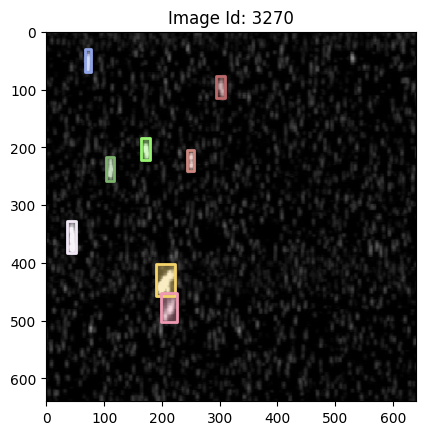

In [4]:
image, target = train_data._get_image(3270, True, True)

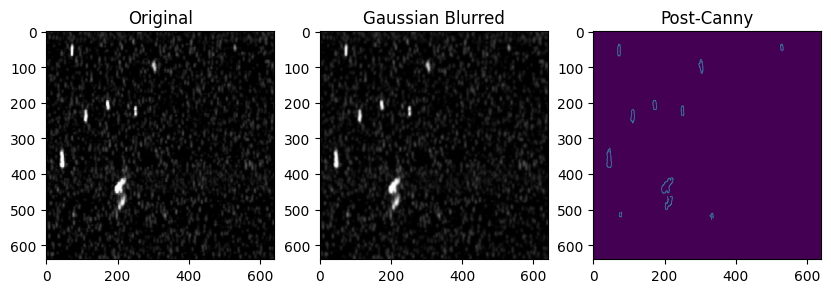

In [5]:
gaussian_image = cv2.GaussianBlur(np.array(image), ksize=(5, 5), sigmaX=2.0)
canny_image = cv2.Canny(gaussian_image, 200, 100)
train_data.show_edited_subplot([image, gaussian_image, canny_image], ["Original", "Gaussian Blurred", "Post-Canny"], "", "")

### 5.2.1 - False Positives

As shown in 5.3, setting the Canny thresholds to (200, 100) began yield positive results like the image above.  However, there are some drawbacks to using static threshold values. Setting the threshold too high can remove key target details or even entire targets. Using a value too small will not remove enough noise and can reduce model performance.  As we see in the below figures, (200, 100) is not a high enough threshold to clear much of the noise from the shoreline, inevitably leading to misclassifications.

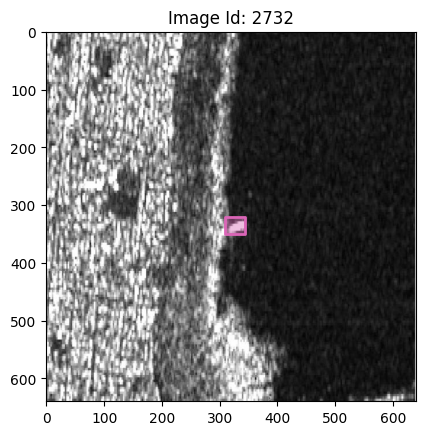

In [6]:
image, target = train_data._get_image(2732, get_image=True)

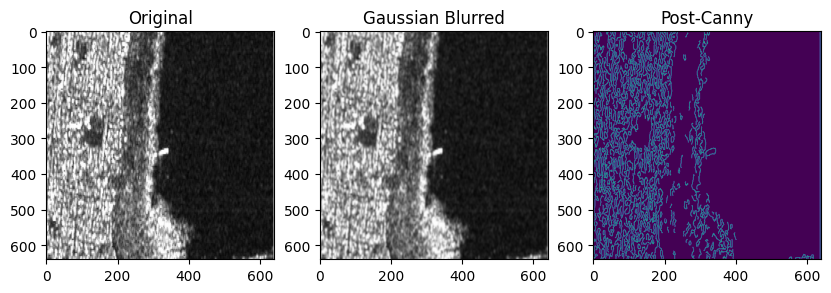

In [7]:
gaussian_image = cv2.GaussianBlur(np.array(image), ksize=(5, 5), sigmaX=2.0)
canny_image = cv2.Canny(gaussian_image, 200, 100)
train_data.show_edited_subplot([image, gaussian_image, canny_image], ["Original", "Gaussian Blurred", "Post-Canny"], "", "")

## Section 5.3 Model Construction and Training

In this section, we build the CannyFRCNN model.  We use a 3x3 kernel and standard deviation of 1 for Gaussian Blurring. For Canny, using 200 or higher for threshold 1 and 100 or higher for threshold 2 began to show good results on most images as this is when noise began being filtered out. 

In [8]:
# Set up train dataloader
train_data = torchvision.datasets.wrap_dataset_for_transforms_v2(train_data, target_keys=("boxes", "labels"))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=train_data._packager)

In [9]:
# Build the baseline model
frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
input_features = frcnn.roi_heads.box_predictor.cls_score.in_features
frcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features, 2)

# Build the loss function and optimizer
optimizer = torch.optim.Adam(frcnn.parameters(), lr=1e-6)

/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
validation_annotations = os.path.join(workspace_builder._data_path, "annotations", "valid_annotations.coco.json")
validation_images = os.path.join(workspace_builder._data_path, "valid")
validation_data = SeaSarFRCNN(validation_images, validation_annotations, transform=tester_transforms)
validation_data = torchvision.datasets.wrap_dataset_for_transforms_v2(validation_data, target_keys=("boxes", "labels"))
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=True, collate_fn=validation_data._packager, num_workers=20)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [11]:
canny_model = CannyFRCNN(frcnn, 'cuda', (3, 3), 1.0, 200, 100)
worker = ModelWorkerFRCNN(optimizer, canny_model, False)

In [12]:
worker.train(train_dataloader, num_epochs=10, indices_to_skip=[3736])

Batch: 4715/4716 | Batch Loss: 2.07755899429321314

############# Epoch: 0 Complete #############
Total Epoch Combined Loss: 1815.5659626051784
Loss Objectness: 1314.7561081200838
RPN Region Proposal Losses: 325.694407816889
Classifier Loss: 164.8143658086192
Bounding Box Region Loss: 10.301081881401316


Batch: 4715/4716 | Batch Loss: 0.23722982406616217

############# Epoch: 1 Complete #############
Total Epoch Combined Loss: 1562.2380555719137
Loss Objectness: 1146.547567203641
RPN Region Proposal Losses: 312.60658126145427
Classifier Loss: 94.33098509034608
Bounding Box Region Loss: 8.75292471790392


Batch: 4715/4716 | Batch Loss: 0.54321897029876714

############# Epoch: 2 Complete #############
Total Epoch Combined Loss: 1540.4652016833425
Loss Objectness: 1145.094962283969
RPN Region Proposal Losses: 311.1188141628227
Classifier Loss: 76.29784493462648
Bounding Box Region Loss: 7.9535788943179435


Batch: 4715/4716 | Batch Loss: 0.15076240897178655

############# Epoch: 3 Compl

In [13]:
# Run validation
worker.validation(validation_dataloader, 10, [])

Batch: 1345/1346 | Batch Loss: 0.17392469942569733

############# Epoch: 0 Complete #############
	Total Epoch Loss: 416.2518005371094
	Loss Objectness: [318.6403874307871]
	RPN Region Proposal Losses: 80.51574573530525
	Classifier Loss: 13.682448629988357
	Bounding Box Region Loss: 3.412949384691643
Batch: 1345/1346 | Batch Loss: 0.71822917461395262

############# Epoch: 1 Complete #############
	Total Epoch Loss: 416.3097229003906
	Loss Objectness: [318.6403874307871, 318.76906932145357]
	RPN Region Proposal Losses: 80.43693993105262
	Classifier Loss: 13.690869222162291
	Bounding Box Region Loss: 3.412949384691643
Batch: 1345/1346 | Batch Loss: 0.23504206538200378

############# Epoch: 2 Complete #############
	Total Epoch Loss: 416.50958251953125
	Loss Objectness: [318.6403874307871, 318.76906932145357, 318.99613758176565]
	RPN Region Proposal Losses: 80.41424248232215
	Classifier Loss: 13.686490925145335
	Bounding Box Region Loss: 3.412949384691643
Batch: 1345/1346 | Batch Loss: 0.

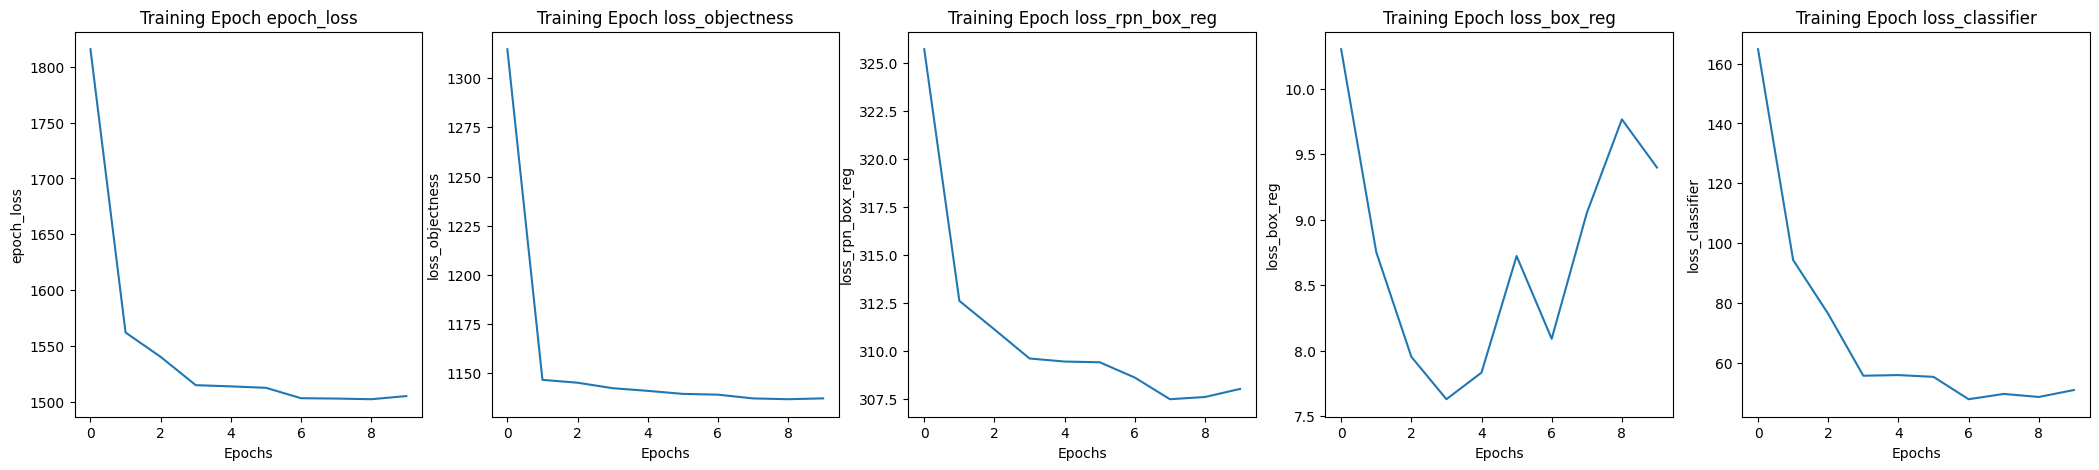

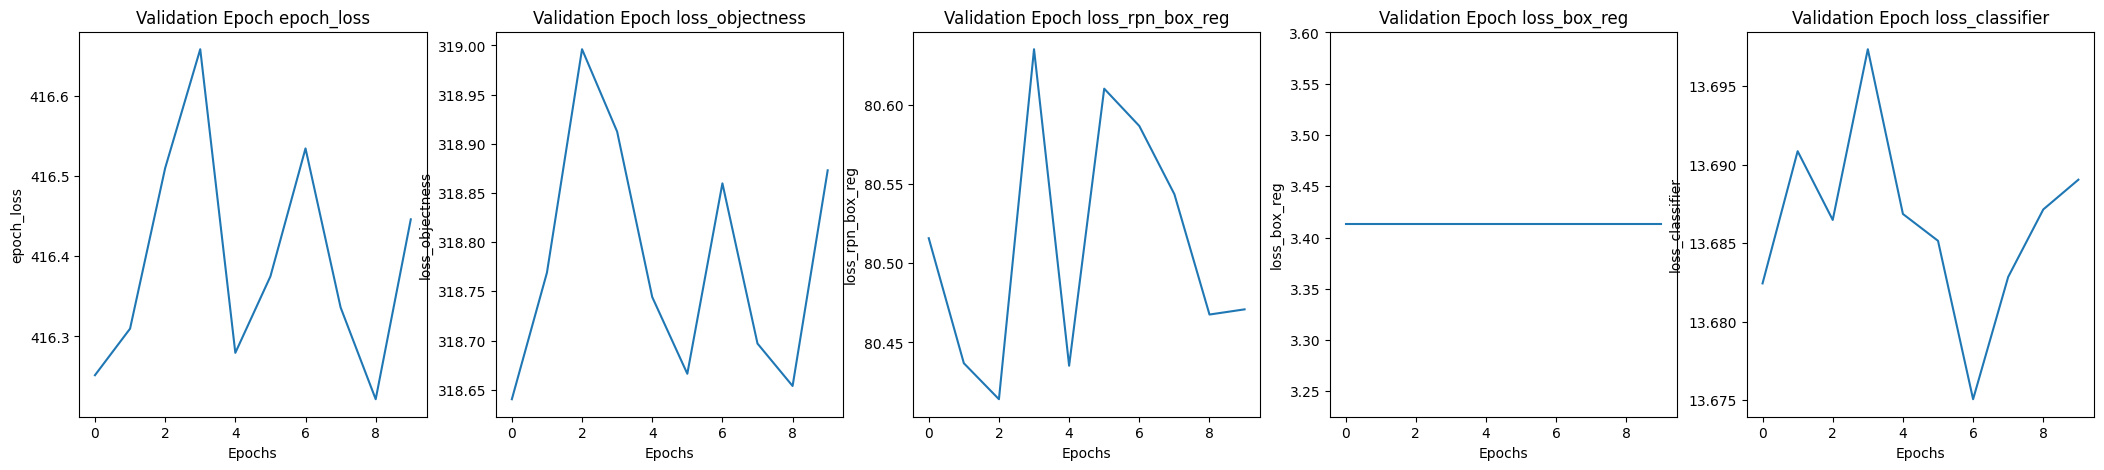

In [14]:
# Plot Baseline training and validation metrics
worker.plot_losses(True)
plt.show()
worker.plot_losses(False)
plt.show()

In [15]:
# Build the baseline model
frcnn_sgd = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
input_features_sgd = frcnn_sgd.roi_heads.box_predictor.cls_score.in_features
frcnn_sgd.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(input_features_sgd, 2)

# Build the loss function and optimizer
sgd = torch.optim.SGD(frcnn_sgd.parameters(), momentum=0.9)
sgdWorker = ModelWorkerFRCNN(optimizer=sgd, frcnn=frcnn_sgd, quiet=False)

/home/jag1799/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
sgdWorker.train(train_dataloader, 10, [3736])

Batch: 4715/4716 | Batch Loss: 0.200562253594398536

############# Epoch: 0 Complete #############
Total Epoch Combined Loss: 1225.9136556703597
Loss Objectness: 179.73313917728228
RPN Region Proposal Losses: 195.1948230119997
Classifier Loss: 326.46275037620217
Bounding Box Region Loss: 524.5229444681472


Batch: 4715/4716 | Batch Loss: 0.126925498247146686

############# Epoch: 1 Complete #############
Total Epoch Combined Loss: 1012.9603334367275
Loss Objectness: 96.73234642859097
RPN Region Proposal Losses: 128.0653562610023
Classifier Loss: 261.01876498688944
Bounding Box Region Loss: 527.1438661501743


Batch: 4715/4716 | Batch Loss: 0.082871146500110634

############# Epoch: 2 Complete #############
Total Epoch Combined Loss: 902.1306973211467
Loss Objectness: 69.69740776512481
RPN Region Proposal Losses: 106.6040712564427
Classifier Loss: 233.49783717980608
Bounding Box Region Loss: 492.33138170314487


Batch: 4715/4716 | Batch Loss: 0.054661575704813004

############# Epoch: 3

In [17]:
sgdWorker.validation(validation_dataloader, 10, [])

Batch: 1345/1346 | Batch Loss: 0.061140768229961395

############# Epoch: 0 Complete #############
	Total Epoch Loss: 218.60508728027344
	Loss Objectness: [18.187851053418626]
	RPN Region Proposal Losses: 22.322698707474046
	Classifier Loss: 56.64040772092994
	Bounding Box Region Loss: 121.45396487577818
Batch: 1345/1346 | Batch Loss: 0.041282750666141516

############# Epoch: 1 Complete #############
	Total Epoch Loss: 219.52651977539062
	Loss Objectness: [18.187851053418626, 18.543258275240078]
	RPN Region Proposal Losses: 22.494191246820264
	Classifier Loss: 56.7909863058012
	Bounding Box Region Loss: 121.69808143540286
Batch: 1345/1346 | Batch Loss: 0.073032297194004066

############# Epoch: 2 Complete #############
	Total Epoch Loss: 218.6449432373047
	Loss Objectness: [18.187851053418626, 18.543258275240078, 18.069847861512812]
	RPN Region Proposal Losses: 22.485580141437822
	Classifier Loss: 56.54817547858693
	Bounding Box Region Loss: 121.54153156443499
Batch: 1345/1346 | Batch

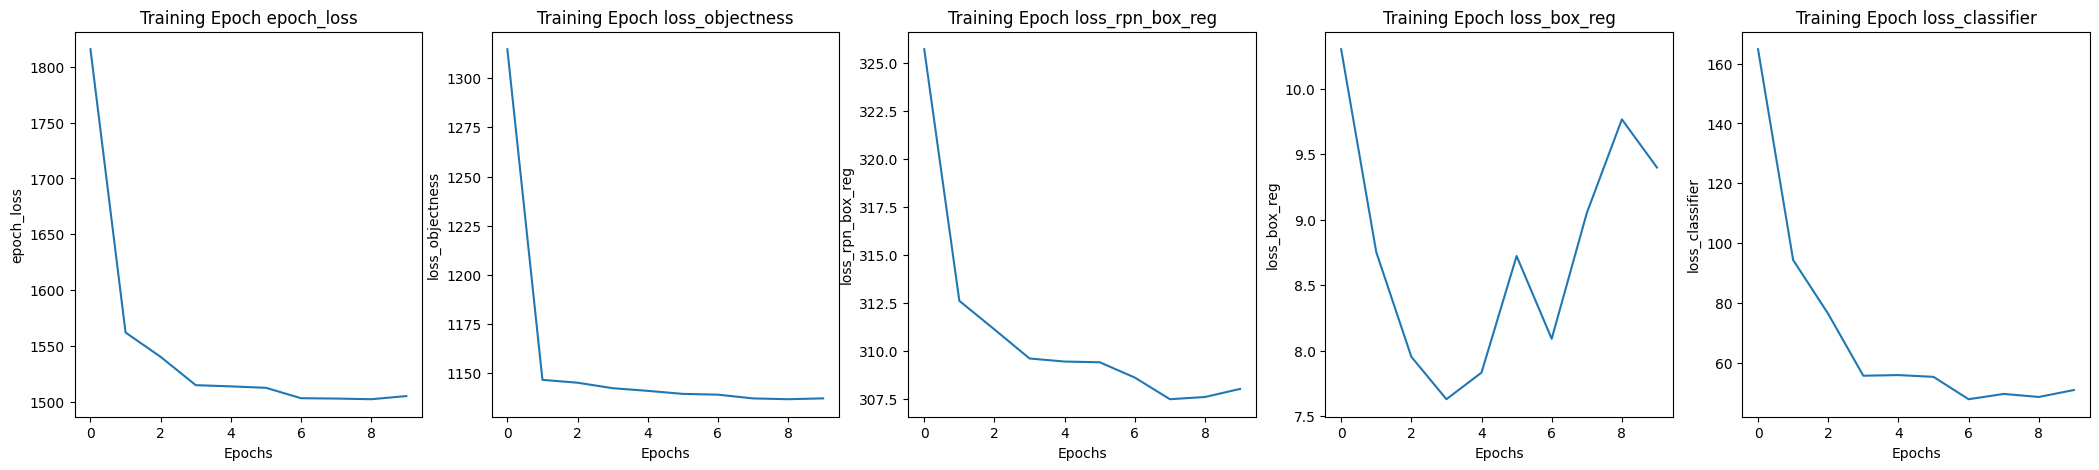

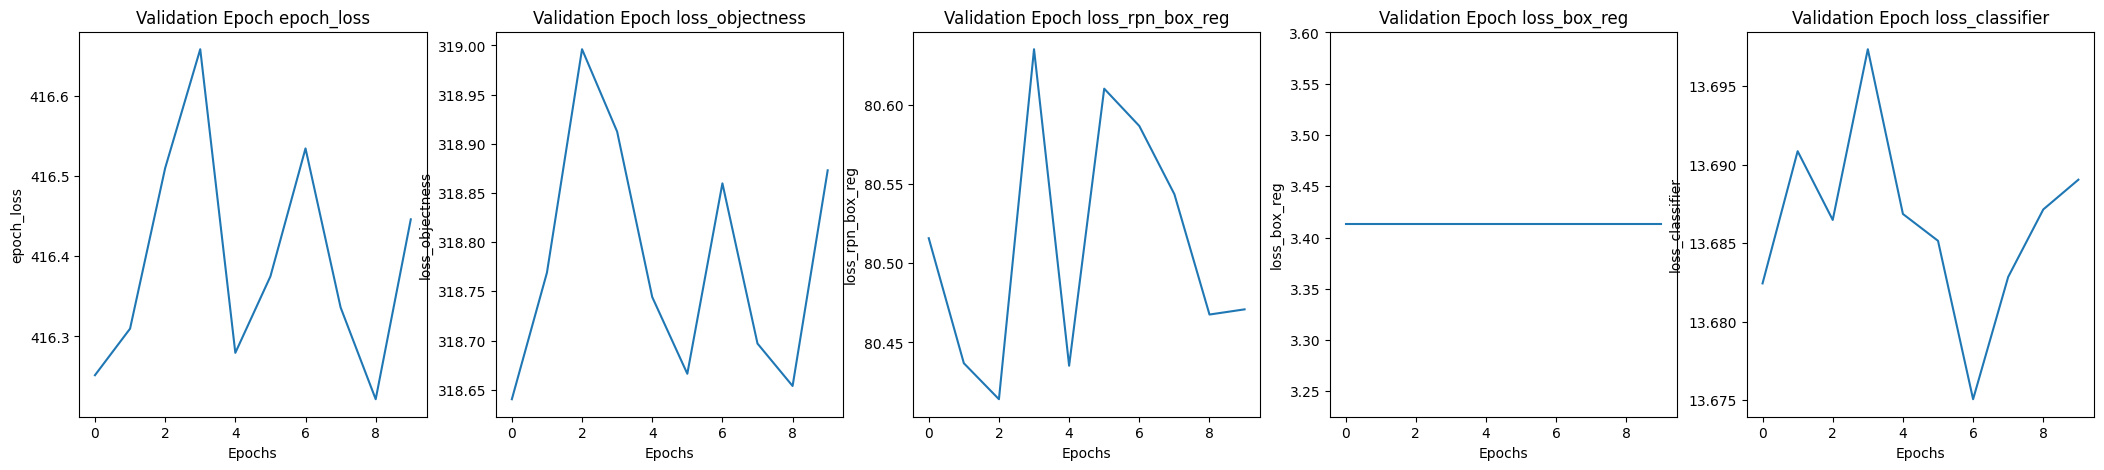

In [18]:
# Plot Baseline training and validation metrics
worker.plot_losses(True)
plt.show()
worker.plot_losses(False)
plt.show()

In [19]:
test_images = os.path.join(workspace_builder._data_path, "test")
test_annotations = os.path.join(workspace_builder._data_path, "annotations", "test_annotations.coco.json")
test_data = SeaSarFRCNN(test_images, test_annotations, transform=tester_transforms)
test_data = torchvision.datasets.wrap_dataset_for_transforms_v2(test_data, target_keys=("boxes", "labels"))
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=test_data._packager, num_workers=20)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [20]:
threshold = 0.5
performance, maP = worker.model_test(test_dataloader, threshold)

In [21]:
performance = worker.get_test_metrics(performance, threshold)

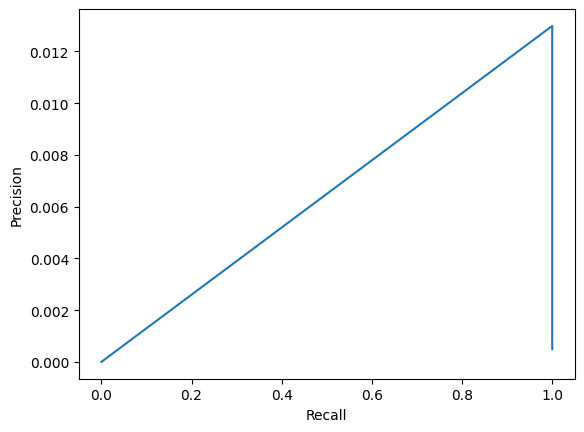

In [22]:
worker.plot_PR_curve(performance)
plt.show()

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MeanAveragePrecision'>)

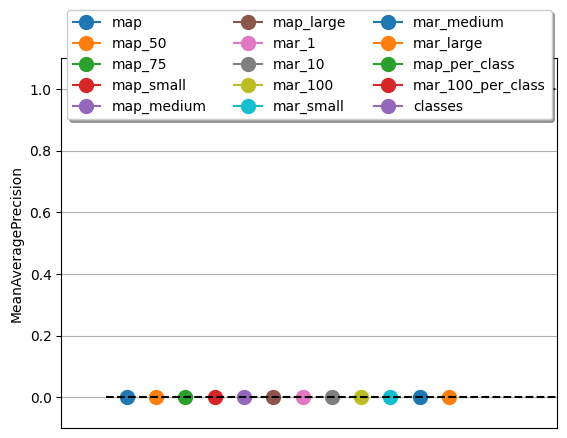

In [23]:
# Plot Mean Average Precision
maP.compute()
maP.plot()

In [24]:
# Compare with Stochastic Gradient Descent optimizer.
threshold = 0.5
performance, maP = sgdWorker.model_test(test_dataloader, threshold)

In [25]:
performance = sgdWorker.get_test_metrics(performance, threshold)

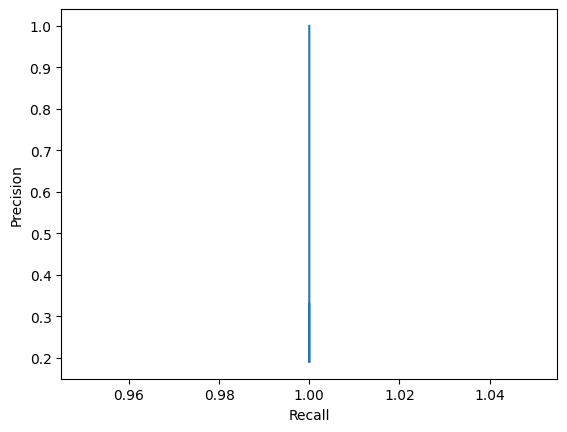

In [26]:
sgdWorker.plot_PR_curve(performance)
plt.show()

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MeanAveragePrecision'>)

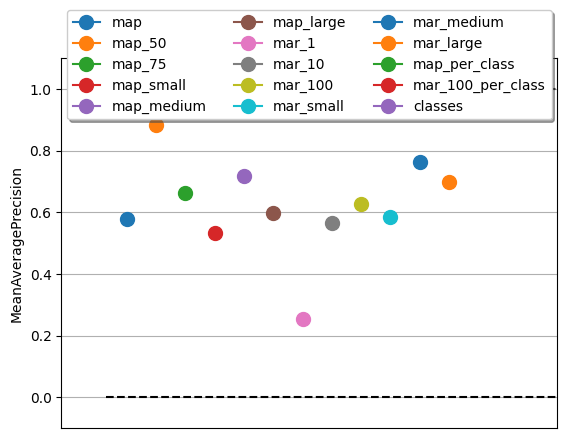

In [27]:
# Plot Mean Average Precision
maP.compute()
maP.plot()